In [1]:
import os
import torch
import random
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.functional import normalize
import torchvision.models as models
import torch.nn.functional as F

In [2]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
    print ("MPS found!")
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')
MPS found!


In [4]:
device = torch.device("mps")
device

device(type='mps')

Train & Val Split Code:

In [11]:
# import os
# import shutil
# import random

# # Path to the gt_bbox folder
# gt_bbox_path = "/Users/annsijaz/Documents/UMT/FYP/Market-1501-v15.09.15/gt_bbox"
# output_train_path = "/Users/annsijaz/Documents/UMT/FYP/final_dataset/gt_bbox_train"
# output_val_path = "/Users/annsijaz/Documents/UMT/FYP/final_dataset/gt_bbox_val"

# # Split ratio (e.g., 20% for validation)
# val_split_ratio = 0.2

# # Create output directories if they don't exist
# os.makedirs(output_train_path, exist_ok=True)
# os.makedirs(output_val_path, exist_ok=True)

# # Get all files in the gt_bbox folder
# files = [f for f in os.listdir(gt_bbox_path) if os.path.isfile(os.path.join(gt_bbox_path, f))]

# # Extract person IDs (PIDs) from filenames (assuming format like 0001_c1s1_000151_01.jpg)
# def extract_pid(filename):
#     return filename.split("_")[0]  # Extract PID from filename

# # Group files by person ID
# pid_to_files = {}
# for file in files:
#     pid = extract_pid(file)
#     if pid not in pid_to_files:
#         pid_to_files[pid] = []
#     pid_to_files[pid].append(file)

# # Shuffle the PIDs for random splitting
# pids = list(pid_to_files.keys())
# random.shuffle(pids)

# # Split PIDs into train and validation sets
# num_val_pids = int(len(pids) * val_split_ratio)
# val_pids = pids[:num_val_pids]
# train_pids = pids[num_val_pids:]

# # Move files to respective train and validation folders
# for pid in train_pids:
#     for file in pid_to_files[pid]:
#         shutil.copy(os.path.join(gt_bbox_path, file), os.path.join(output_train_path, file))

# for pid in val_pids:
#     for file in pid_to_files[pid]:
#         shutil.copy(os.path.join(gt_bbox_path, file), os.path.join(output_val_path, file))

# print(f"Split complete! Training data: {len(train_pids)} PIDs, Validation data: {len(val_pids)} PIDs.")

Split complete! Training data: 1202 PIDs, Validation data: 300 PIDs.


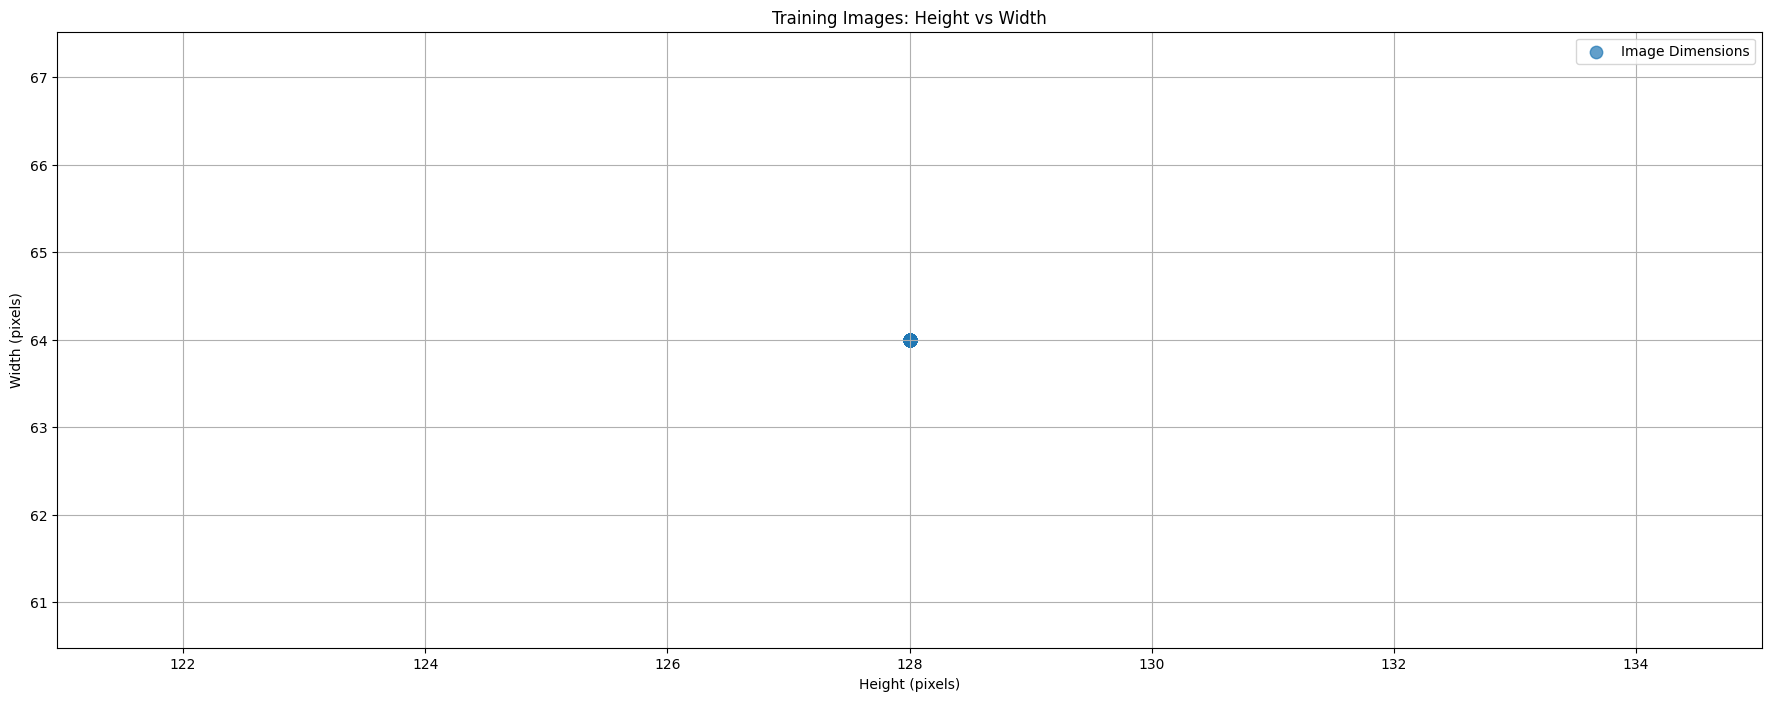

In [34]:
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt


def process_image(file_path):
    with Image.open(file_path) as img:
        width, height = img.size
        return width, height

def collect_dimensions(image_dir):
    dimensions = []

    with ThreadPoolExecutor() as executor:
        futures = []
        for file_name in os.listdir(image_dir):
            file_path = os.path.join(image_dir, file_name)
            if os.path.isfile(file_path) and file_name.lower().endswith(('jpg', 'jpeg')):
                futures.append(executor.submit(process_image, file_path))

        for future in futures:
            result = future.result()
            if result:
                dimensions.append(result)

    return dimensions

def plot_histogram(dimensions, title):
    heights = [dim[1] for dim in dimensions]
    widths = [dim[0] for dim in dimensions]

    plt.figure(figsize=(22, 8))
    plt.scatter(heights, widths, alpha=0.7, s=80, label="Image Dimensions")
    plt.title(title)
    plt.xlabel("Height (pixels)")
    plt.ylabel("Width (pixels)")
    plt.grid(True)
    plt.legend()
    plt.show()

train_dimensions = collect_dimensions(train_dir)
plot_histogram(train_dimensions, "Training Images: Height vs Width")

In [5]:
class MarketDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for img_name in os.listdir(data_dir):
            if img_name.endswith('.jpg'):
                self.image_paths.append(img_name)
                person_id = int(img_name.split('_')[0])
                self.labels.append(person_id)

        # Create a mapping for person IDs to indices
        self.id_to_indices = {}
        for idx, label in enumerate(self.labels):
            if label not in self.id_to_indices:
                self.id_to_indices[label] = []
            self.id_to_indices[label].append(idx)

        # Initialize anchor tracking
        self.anchor_class_iterator = iter(self.id_to_indices.keys())
        self.current_anchor_class = next(self.anchor_class_iterator, None)
        self.current_anchor_indices = iter(self.id_to_indices[self.current_anchor_class])
        self.current_anchor_idx = None
        self.current_positive_idx = 0  # Start with the first positive index

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = os.path.join(self.data_dir, self.image_paths[index])
        label = self.labels[index]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

    def get_triplet(self):
        if self.current_anchor_idx is None:
            # Initialize the first anchor for the current class
            self.current_anchor_idx = self.id_to_indices[self.current_anchor_class][0]
            self.current_positive_idx = 1  # Start with the second image for positive

        # Get the current anchor
        anchor_idx = self.current_anchor_idx

        # Positive sampling: Iterate through the positives of the same class
        positive_idx = self.id_to_indices[self.current_anchor_class][self.current_positive_idx]
        
        # Move to the next positive sample in the same class
        self.current_positive_idx += 1

        # If we exhaust all positives for the current anchor, move to the next class
        if self.current_positive_idx >= len(self.id_to_indices[self.current_anchor_class]):
            # Move to the next class and reset positive index
            try:
                self.current_anchor_class = next(self.anchor_class_iterator)
                self.current_anchor_idx = self.id_to_indices[self.current_anchor_class][0]
                self.current_positive_idx = 1
            except StopIteration:
                # All classes exhausted, start over from the beginning
                self.anchor_class_iterator = iter(self.id_to_indices.keys())
                self.current_anchor_class = next(self.anchor_class_iterator)
                self.current_anchor_idx = self.id_to_indices[self.current_anchor_class][0]
                self.current_positive_idx = 1

        # Negative sampling: Choose a random sample from a different class
        negative_class = random.choice([cls for cls in self.id_to_indices.keys() if cls != self.current_anchor_class])
        negative_idx = random.choice(self.id_to_indices[negative_class])

        return anchor_idx, positive_idx, negative_idx


class TripletDataset(Dataset):
    def __init__(self, Market_dataset, indices=None):
        self.Market_dataset = Market_dataset
        self.indices = indices if indices else list(range(len(Market_dataset)))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        # Fetch the triplet using the get_triplet method of MarketDataset
        dataset_idx = self.indices[index]
        anchor_idx, positive_idx, negative_idx = self.Market_dataset.get_triplet()
        anchor, _ = self.Market_dataset[anchor_idx]
        positive, _ = self.Market_dataset[positive_idx]
        negative, _ = self.Market_dataset[negative_idx]
        return anchor, positive, negative


transform = transforms.Compose([
    transforms.Resize((128, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

data_dir = "/Users/annsijaz/Documents/UMT/FYP/final_dataset/train"
Market_dataset = MarketDataset(data_dir, transform=transform)
triplet_dataset = TripletDataset(Market_dataset)

# Example: Fetch and display a triplet
anchor, positive, negative = triplet_dataset[0]
print("Anchor shape:", anchor.shape)
print("Positive shape:", positive.shape)
print("Negative shape:", negative.shape)

Anchor shape: torch.Size([3, 128, 64])
Positive shape: torch.Size([3, 128, 64])
Negative shape: torch.Size([3, 128, 64])


In [62]:
train_dir = "/Users/annsijaz/Documents/UMT/FYP/final_dataset/train"
valid_dir = "/Users/annsijaz/Documents/UMT/FYP/final_dataset/val"
test_dir = "/Users/annsijaz/Documents/UMT/FYP/final_dataset/test" 

In [80]:
train_dataset = MarketDataset(train_dir, transform=transform)
val_dataset = MarketDataset(valid_dir, transform=transform)
test_dataset = MarketDataset(test_dir, transform=transform)

train_triplet_dataset = TripletDataset(train_dataset)
val_triplet_dataset = TripletDataset(val_dataset)
test_triplet_dataset = TripletDataset(test_dataset)

train_loader = DataLoader(train_triplet_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_triplet_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_triplet_dataset, batch_size=4, shuffle=False)

In [64]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
train_indices = MarketDataset(train_dir, transform=transform)
val_indices = MarketDataset(valid_dir, transform=transform)

Triplet 1:
  Anchor: /Users/annsijaz/Documents/UMT/FYP/final_dataset/train/1025_c5s2_132999_00.jpg
  Positive: /Users/annsijaz/Documents/UMT/FYP/final_dataset/train/1025_c6s2_126218_00.jpg
  Negative: /Users/annsijaz/Documents/UMT/FYP/final_dataset/train/0598_c6s2_038993_00.jpg


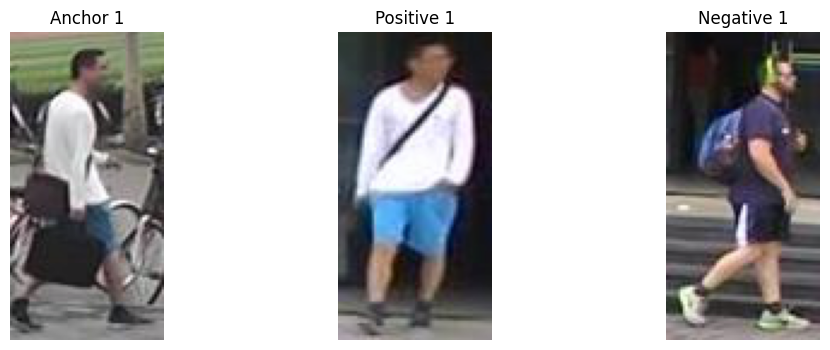

Triplet 2:
  Anchor: /Users/annsijaz/Documents/UMT/FYP/final_dataset/train/1025_c5s2_132999_00.jpg
  Positive: /Users/annsijaz/Documents/UMT/FYP/final_dataset/train/1025_c6s2_126168_00.jpg
  Negative: /Users/annsijaz/Documents/UMT/FYP/final_dataset/train/0386_c2s3_074602_00.jpg


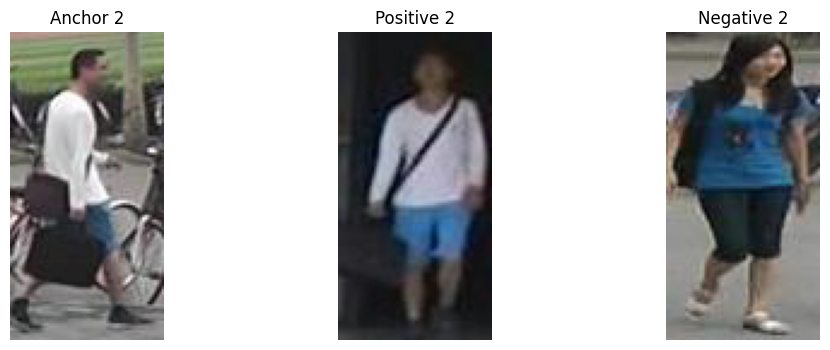

Triplet 3:
  Anchor: /Users/annsijaz/Documents/UMT/FYP/final_dataset/train/1025_c5s2_132999_00.jpg
  Positive: /Users/annsijaz/Documents/UMT/FYP/final_dataset/train/1025_c3s2_132069_00.jpg
  Negative: /Users/annsijaz/Documents/UMT/FYP/final_dataset/train/0077_c4s1_018401_00.jpg


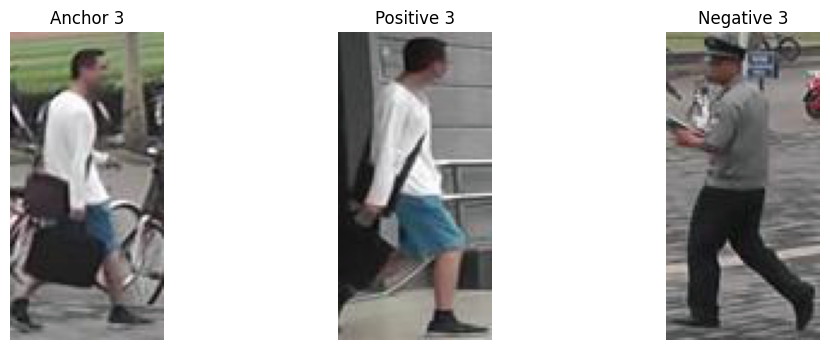

Triplet 4:
  Anchor: /Users/annsijaz/Documents/UMT/FYP/final_dataset/train/1025_c5s2_132999_00.jpg
  Positive: /Users/annsijaz/Documents/UMT/FYP/final_dataset/train/1025_c6s2_126443_00.jpg
  Negative: /Users/annsijaz/Documents/UMT/FYP/final_dataset/train/0145_c3s1_031251_00.jpg


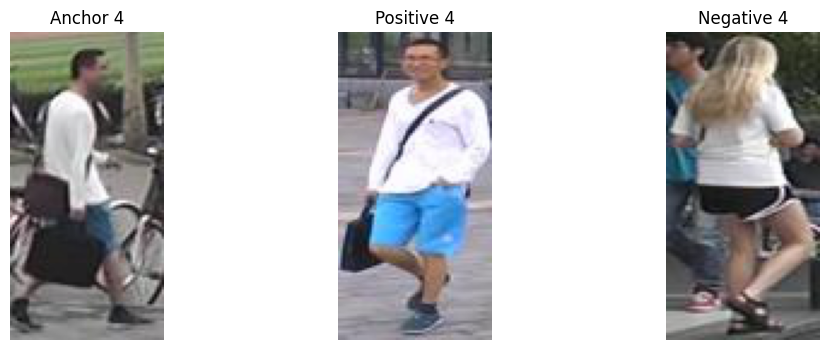

Triplet 5:
  Anchor: /Users/annsijaz/Documents/UMT/FYP/final_dataset/train/1025_c5s2_132999_00.jpg
  Positive: /Users/annsijaz/Documents/UMT/FYP/final_dataset/train/1025_c3s2_132219_00.jpg
  Negative: /Users/annsijaz/Documents/UMT/FYP/final_dataset/train/0704_c6s2_049593_00.jpg


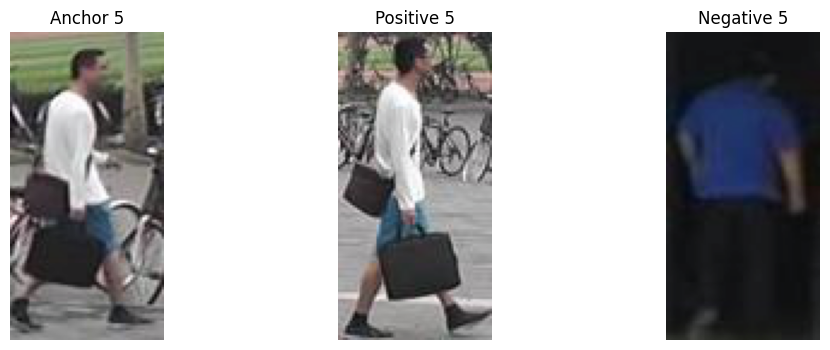

Triplet 6:
  Anchor: /Users/annsijaz/Documents/UMT/FYP/final_dataset/train/1025_c5s2_132999_00.jpg
  Positive: /Users/annsijaz/Documents/UMT/FYP/final_dataset/train/1025_c1s4_071861_00.jpg
  Negative: /Users/annsijaz/Documents/UMT/FYP/final_dataset/train/0811_c5s2_106077_00.jpg


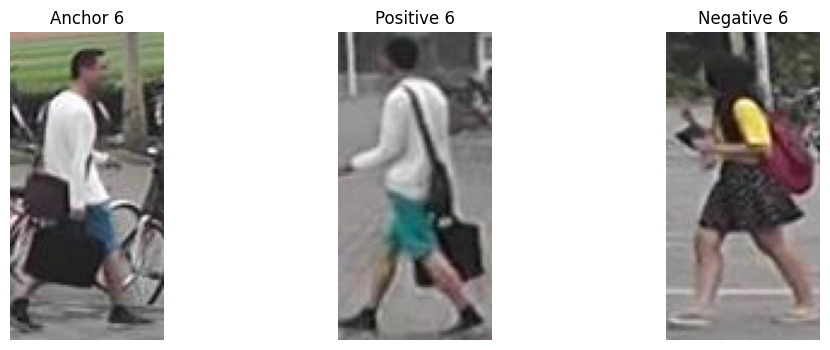

In [ ]:
def to_numpy(tensor_img):
    img_np = tensor_img.permute(1, 2, 0).numpy()
    img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img_np = (img_np * 255).astype('uint8')
    return img_np


def show_triplet_samples(dataset, num_samples):
    for i in range(num_samples):
        anchor_idx, positive_idx, negative_idx = dataset.get_triplet()

        #Confirm this code (reminder)
        anchor, anchor_label = dataset[anchor_idx]
        positive, positive_label = dataset[positive_idx]
        negative, negative_label = dataset[negative_idx]

        anchor_path = os.path.join(dataset.data_dir, dataset.image_paths[anchor_idx])
        positive_path = os.path.join(dataset.data_dir, dataset.image_paths[positive_idx])
        negative_path = os.path.join(dataset.data_dir, dataset.image_paths[negative_idx])

        print(f"Triplet {i + 1}:")
        print(f"  Anchor: {anchor_path}")
        print(f"  Positive: {positive_path}")
        print(f"  Negative: {negative_path}")

        fig = plt.figure(figsize=(12, 4))

        ax1 = fig.add_subplot(1, 3, 1)
        ax1.imshow(to_numpy(anchor))
        ax1.set_title(f"Anchor {i + 1}")
        ax1.axis("off")

        ax2 = fig.add_subplot(1, 3, 2)
        ax2.imshow(to_numpy(positive))
        ax2.set_title(f"Positive {i + 1}")
        ax2.axis("off")

        ax3 = fig.add_subplot(1, 3, 3)
        ax3.imshow(to_numpy(negative))
        ax3.set_title(f"Negative {i + 1}")
        ax3.axis("off")

        plt.show()

show_triplet_samples(Market_dataset, 6)

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_dim=128):
        super(SiameseNetwork, self).__init__()
        
        # Load ResNet-50 backbone
        resnet = models.resnet50(pretrained=True)
        
        # Modify the first conv layer for smaller input dimensions as resnet expects a different size of input of image
        resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        resnet.maxpool = nn.Identity()  # Remove maxpool layer to preserve spatial dimensions
        
        # Extract convolutional layers (exclude the fully connected layers)
        self.resnet_backbone = nn.Sequential(*list(resnet.children())[:-2])  # Up to the final conv layer
        
        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully connected layer for embedding
        self.fc = nn.Linear(2048, embedding_dim)
        
    def forward_one(self, x):
        x = self.resnet_backbone(x)  # Extract features
        x = self.gap(x)  # Global Average Pooling
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)  # Fully connected for embedding
        return nn.functional.normalize(x, p=2, dim=1)  # L2 normalization

    def forward(self, anchor, positive, negative):
        anchor_embedding = self.forward_one(anchor)
        positive_embedding = self.forward_one(positive)
        negative_embedding = self.forward_one(negative)
        return anchor_embedding, positive_embedding, negative_embedding
    
# Triplet loss function
class TripletLossModel(nn.Module):
    def __init__(self, model, margin=1.0):
        super(TripletLossModel, self).__init__()
        self.model = model
        self.triplet_loss = nn.TripletMarginLoss(margin=margin)

    def forward(self, anchor, positive, negative):
        anchor_embedding, positive_embedding, negative_embedding = self.model(anchor, positive, negative)
        loss = self.triplet_loss(anchor_embedding, positive_embedding, negative_embedding)
        return loss
    
# Training Loop
def train(model, train_loader, optimizer, epoch):
    model.train()
    running_loss = 0.0
    for i, (anchor, positive, negative) in enumerate(train_loader):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        
        optimizer.zero_grad()
        
        loss = model(anchor, positive, negative)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch}: Training Loss: {running_loss / len(train_loader)}")

# Validation Loop
def validate(model, val_loader):
    model.eval()
    with torch.no_grad():
        for i, (anchor, positive, negative) in enumerate(val_loader):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            loss = model(anchor, positive, negative)
            print(f"Validation Loss: {loss.item()}")

# Testing Loop
def test(model, test_loader):
    model.eval()
    with torch.no_grad():
        for i, (anchor, positive, negative) in enumerate(test_loader):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            anchor_embedding, positive_embedding, negative_embedding = model(anchor, positive, negative)
            
            # For testing, you can compute the similarity/distance between the embeddings
            print(f"Testing: Similarity between anchor and positive: {F.cosine_similarity(anchor_embedding, positive_embedding)}")
            print(f"Testing: Similarity between anchor and negative: {F.cosine_similarity(anchor_embedding, negative_embedding)}")

embedding_dim = 128
model = SiameseNetwork(embedding_dim).to(device)
triplet_loss_model = TripletLossModel(model).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train(triplet_loss_model, train_loader, optimizer, epoch + 1)
    validate(triplet_loss_model, val_loader)

# Testing after training
test(triplet_loss_model, test_loader)